In [44]:
# Standard library imports
import sys
import warnings
import joblib
import os


# Third-party library imports
import pandas as pd
import scipy.stats as stats
import xgboost as xg
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Adding 'src' folder path to import path
sys.path.append('../src')

# Local application imports (custom modules)
from classes import Auxiliaries, Modelling, Plot

In [45]:
# Create objects for data visualization and modeling
plotter = Plot(figsize=(10, 6), palette='viridis')
modelling = Modelling()
aux = Auxiliaries(plotter)

# Ignore warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# read the csv file
data = pd.read_csv("../data/teste_indicium_precificacao.csv")

In [47]:
# convert 'ultima_review' in data format
data['ultima_review'] = pd.to_datetime(data['ultima_review'])

# Análise Explorátoria dos Dados

##  Análise por Bairro - ```bairro_group```

A seguir, analisamos a variável `bairro_group`, que indica o bairro onde cada anúncio está localizado.       

Observamos que a maioria dos anúncios estão concentrados em **Manhattan** e no **Brooklyn**, que juntos representam mais de 80% do total. **Manhattan** se destaca como o bairro com a maior quantidade de anúncios, correspondendo a 44,3% do total, seguido pelo Brooklyn, que representa pouco mais de 40%.    

Os demais bairros — **Queens**, **Bronx** e **Staten Island** — possuem uma participação menor no número de anúncios. Queens e Bronx representam cada um menos de 12%, enquanto **Staten Island** apresenta a menor proporção, com apenas 0,8% dos anúncios.

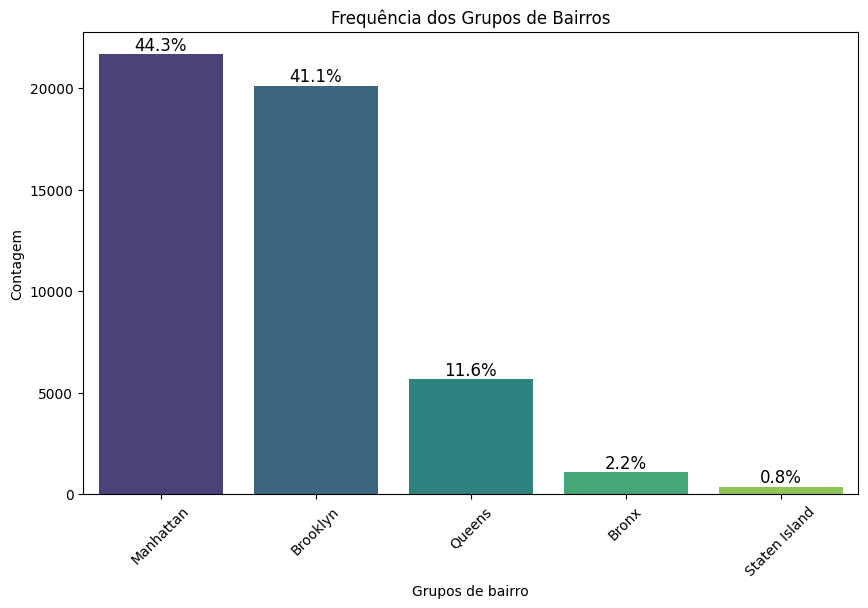

In [48]:
# Bairro group count
bairro_group_count = data["bairro_group"].value_counts().reset_index()
bairro_group_count.columns = ["bairro_group", "count"]

# Using Plot class to plot bar graph
plotter.barplot(
    data=bairro_group_count,
    x_col="bairro_group",
    y_col="count",
    title="Frequência dos Grupos de Bairros",
    xlabel="Grupos de bairro",
    ylabel="Contagem",
    rotation=45,
    show_percentage=True,
)
 


A seguir, analisamos também o preço médio dos grupos de bairros. Observamos que os dois bairros com maior número de anúncios, **Manhattan** e **Brooklyn**, também apresentam os preços médios mais elevados. Manhattan possui o maior valor, com uma média de 197 dólares por noite, enquanto o **Brooklyn** apresenta um preço médio de 124 dólares.    

Nos bairros com menor quantidade de anúncios, a relação entre participação e preço médio se altera. Apesar de **Staten Island**representar apenas 0,8% dos anúncios, seu preço médio é de 115 dólares, superior ao de Queens e Bronx. Além disso, o valor médio de **Staten Island** se aproxima do preço médio do **Brooklyn**, destacando-se entre os bairros com menor número de anúncios.

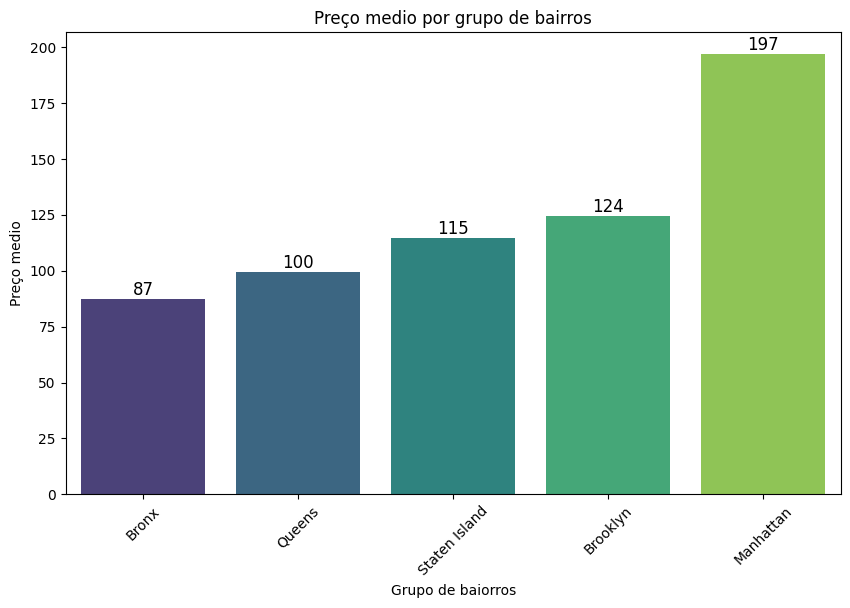

In [49]:
# Calculate the mean price by room type
mean_price_by_room_type = (
    data.groupby("bairro_group")["price"].mean().sort_values()
)

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="bairro_group",
    y_col="price",
    title="Preço medio por grupo de bairros",
    xlabel="Grupo de baiorros",
    ylabel="Preço medio",
    rotation=45,
    show_percentage=False,
)


Na análise a seguir, observamos um comportamento interessante: os dois bairros com maior número de anúncios apresentam os menores números médios de avaliações. **Manhattan** possui, em média, 21 avaliações por anúncio, enquanto **Brooklyn** tem 24.    

Por outro lado, os bairros com menor quantidade de anúncios se destacam por terem um maior número médio de avaliações. **Staten Island** apresenta a maior média, com 31 avaliações por anúncio, seguido por **Queens**, com 28, e **Bronx**, com 26. Esse resultado contrasta com as análises anteriores, indicando que, embora **Manhattan** e **Brooklyn** concentrem a maior parte dos anúncios e tenham os preços mais elevados, os bairros com menos anúncios parecem ter uma maior interação dos hóspedes, refletida no maior número de avaliações.

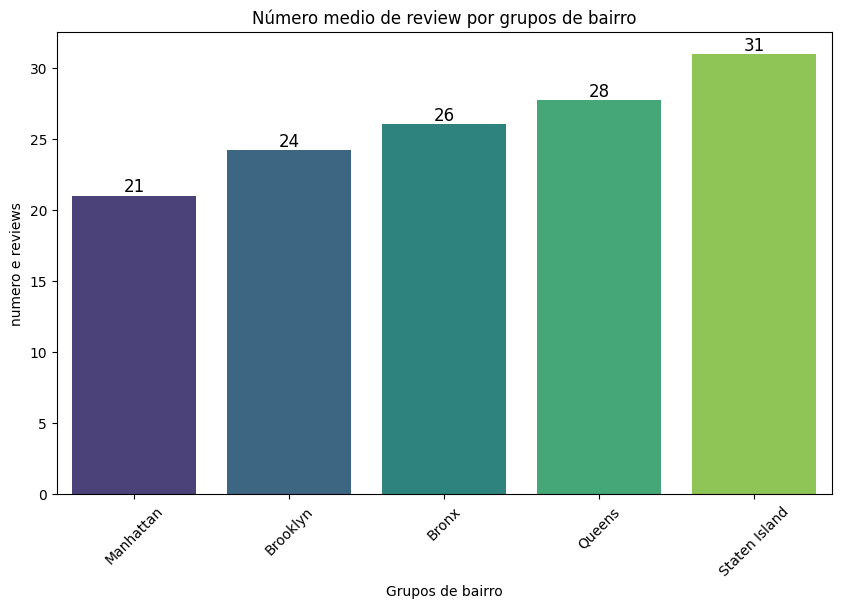

In [50]:
# Calculate the mean price by bairro_group
mean_price_by_bairro_group = (
    data.groupby("bairro_group")["numero_de_reviews"].mean().sort_values()
)

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_bairro_group_df = mean_price_by_bairro_group.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_bairro_group_df,
    x_col="bairro_group",
    y_col="numero_de_reviews",
    title="Número medio de review por grupos de bairro",
    xlabel="Grupos de bairro",
    ylabel="numero e reviews",
    rotation=45,
    show_percentage=False,
)


# Análise por tipos de quarto - `room_type`

A análise da variável **tipo de quarto** (`room_type`), que indica o tipo de espaço de cada anúncio, revela que os tipos de espaço mais comuns são **casa inteira** e **quartos privados**. Esses dois tipos de espaço representam a maior parte dos anúncios, sugerindo que os clientes preferem opções que ofereçam maior **privacidade e conforto**. Isso reflete a tendência de que os hóspedes buscam locais mais exclusivos, como casas inteiras e quartos privados, para garantir uma experiência mais intimista durante a estadia.

Em contrapartida, o número de anúncios de **quartos compartilhados** é significativamente menor, indicando que esse tipo de espaço tem uma procura bem mais baixa. Isso sugere que as pessoas, em sua maioria, preferem pagar um pouco mais por maior privacidade, ao invés de optar por um ambiente compartilhado, que pode oferecer uma experiência menos confortável. 

Portanto, a análise sugere que a busca por privacidade é um fator importante para os clientes, com **casas inteiras** e **quartos privados** sendo as opções mais procuradas.

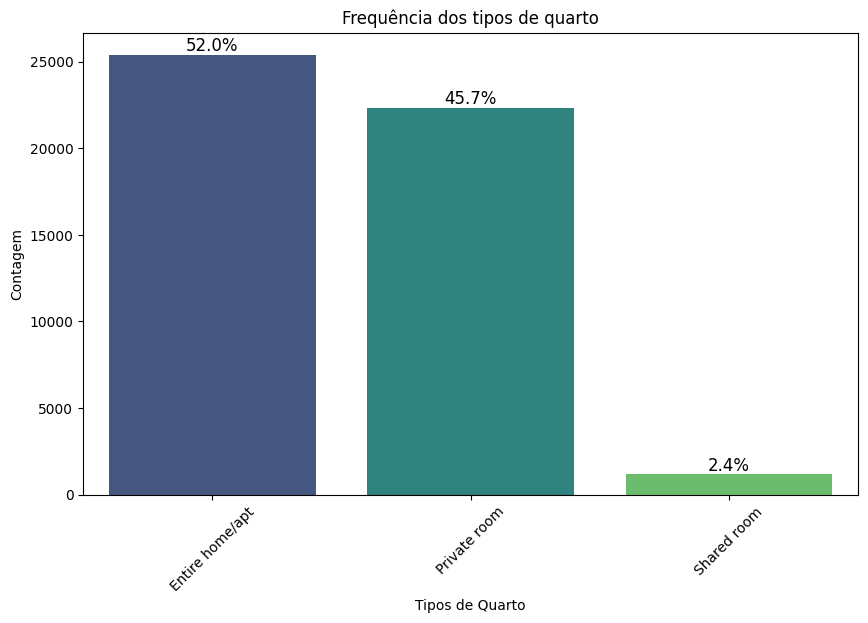

In [51]:
# Room type count
room_type_count = data["room_type"].value_counts().reset_index()
room_type_count.columns = ["room_type", "count"]

# Using Plot class to plot bar graph
plotter.barplot(
    data=room_type_count,
    x_col="room_type",
    y_col="count",
    title="Frequência dos tipos de quarto",
    xlabel="Tipos de Quarto",
    ylabel="Contagem",
    rotation=45,
    show_percentage=True,
)


A análise do tipo de espaço revelou que há uma variação significativa nos preços médios. O tipo de espaço com a média de preço mais alta é a **casa inteira**, que tem um valor superior a 200 dólares. Esse preço mais elevado pode ser justificado pela maior privacidade, conforto e capacidade de acomodar mais pessoas, características que tornam as casas inteiras uma opção mais cara em comparação com os outros tipos de espaço.

Por outro lado, os outros tipos de espaço, como **quartos privados** e **quartos compartilhados**, apresentam uma média de preço bem mais baixa, com valores abaixo de 100 dólares. Isso se deve ao fato de que esses espaços oferecem menos privacidade e têm uma capacidade de acomodação reduzida, o que geralmente resulta em preços mais acessíveis.

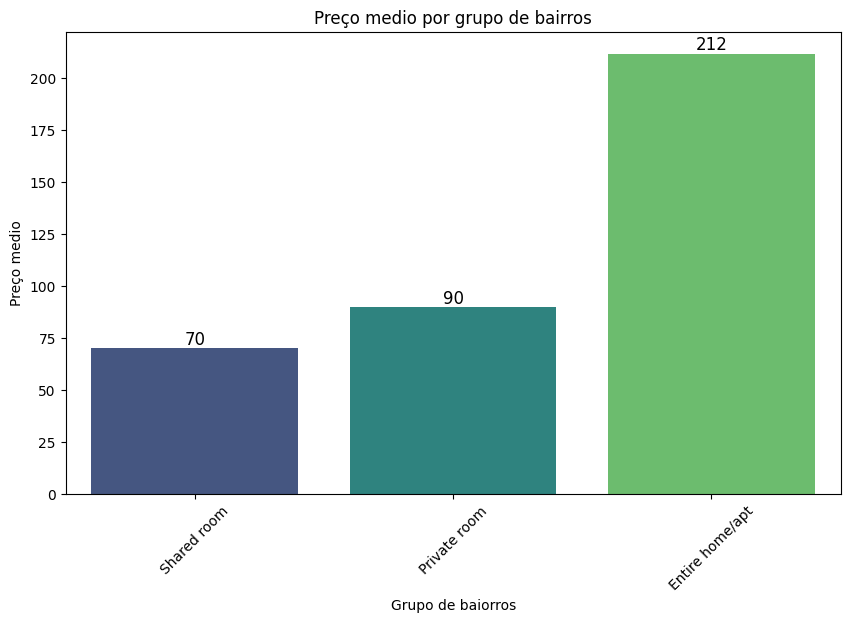

In [52]:
# Calculate the mean price by room_type
mean_price_by_room_type = data.groupby("room_type")["price"].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="room_type",
    y_col="price",
    title="Preço medio por grupo de bairros",
    xlabel="Grupo de Bairros",
    ylabel="Preço Médio",
    rotation=45,
    show_percentage=False,
)


## Análise por nome e textos - ```nome```

Abaixo, apresentamos a análise dos nomes mais comuns na variável `nome`, que representa o título do anúncio.  

Essas palavras são utilizadas para atrair clientes e fornecer uma breve descrição do espaço. Entre as mais frequentes, destacam-se:  

- **heart** – coração  
- **private** – privado  
- **room** – quarto  
- **apartment** – apartamento  
- **cozy** – aconchegante  
- **home** – lar/casa  
- **spacious** – espaçoso  

Essas palavras enfatizam o conforto e as características do local, ajudando a tornar os anúncios mais atrativos para os possíveis hóspedes.

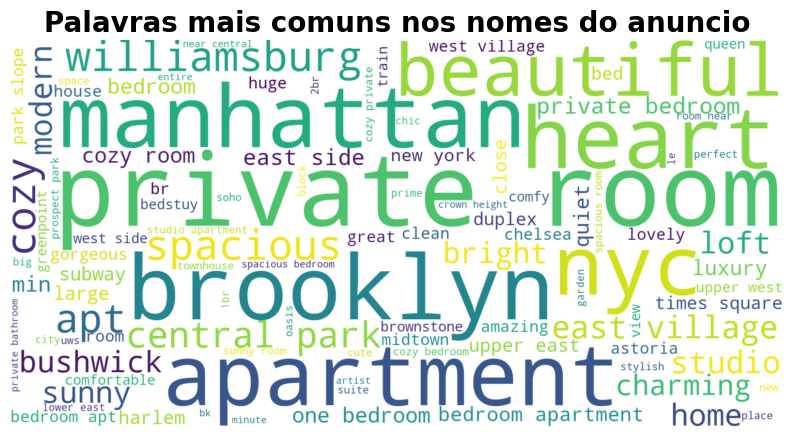

In [ ]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_commom_words = plotter.plot_wordcloud(
    data, text_column="nome", title="Palavras mais comuns nos nomes do anuncio"
)


## Análise por gênero - ```host_name```

Para a análise a seguir, realizamos um pré-processamento nos dados e criamos uma nova coluna a partir da variável `host_name`, que contém o nome do anfitrião do anúncio. O objetivo foi identificar o gênero do anunciante, permitindo avaliar possíveis diferenças nos preços ou no número de anúncios com base nesse critério.  

Os resultados mostram que a categoria mais comum é "Andy" ou andróginos – nomes que não conseguimos classificar com precisão –, representando 26% do total. Além disso, alguns nomes não puderam ser rotulados como masculinos ou femininos, sendo categorizados como "Desconhecido".  

No geral, observamos que há mais anfitriões do gênero masculino do que feminino, com os homens representando 24,8% dos anúncios, enquanto as mulheres correspondem a 21,2%.

['female' 'unknown' 'male' 'andy']


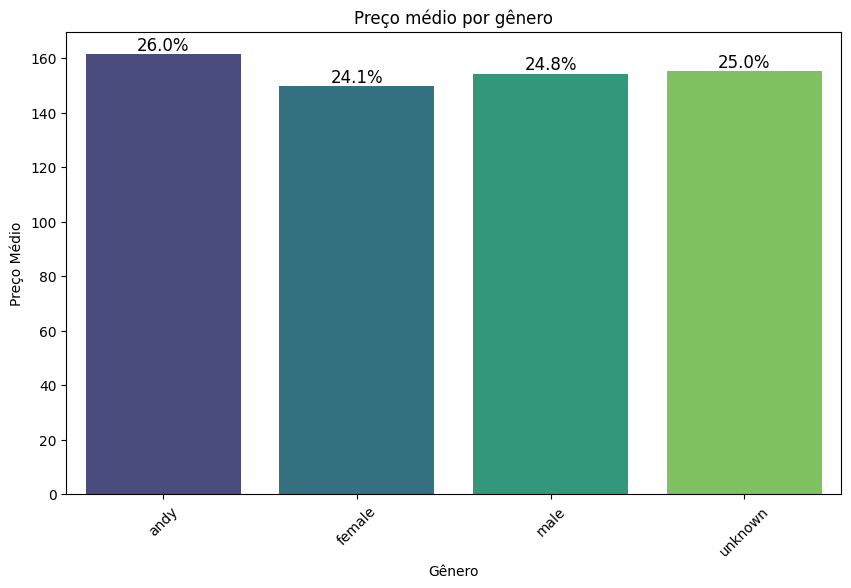

In [ ]:
# Apply predict_gender in 'host_name' column
data["gender"] = data["host_name"].apply(lambda name: aux.predict_gender(name))

# Replace specific gender values for consistency
data["gender"] = data["gender"].replace({"mostly_female": "female", "mostly_male": "male"})

# Check the unique values in the 'gender' column
print(data["gender"].unique())

# Group by 'gender' and calculate the mean price
gender_price_mean = data.groupby("gender")["price"].mean().reset_index()

# Use the Plot class to generate a bar chart
plotter.barplot(
    data=gender_price_mean,
    x_col="gender",
    y_col="price",
    title="Preço médio por gênero",
    xlabel="Gênero",
    ylabel="Preço Médio",
    rotation=45,
)



## Análise de Preços - ```price```

Continuaremos nossas análises com a coluna `price`, que contém o preço por noite em dólares listado pelo anfitrião.  

Podemos ver pelo gráfico boxplot que os preços apresentam alta variabilidade, o que pode gerar dificuldades nas previsões no futuro. O boxplot revela que a maioria dos valores estão concentrados em pontos discrepantes, com valores acima de 1.000 dólares situados fora da faixa do boxplot.  

Analisando os principais percentis dos preços, temos os seguintes valores:


- **Mínimo (0%)**: 0,00 – Este valor representa o menor preço registrado na base de dados, sem considerar os outliers. Um valor de 0,00 pode indicar casos atípicos ou erros de inserção de dados, ou até mesmo anúncios gratuitos.  

- **Primeiro quartil (25%)**: 69,00 – 25% dos preços dos anúncios estão abaixo de 69,00 dólares.A maioria dos preços está concentrada abaixo desse valor, sugerindo que uma boa parte dos anúncios possui preços mais baixos. 

- **Mediana (50%)**: 106,00 – A mediana representa o valor central da distribuição de preços. 

- **Terceiro quartil (75%)**: 175,00 – 75% dos preços dos anúncios estão abaixo de 175,00 dólares.

- **Máximo (100%)**: 10.000,00 – Este é o maior preço registrado, sem considerar outliers. O valor de 10.000 dólares é um exemplo de um preço extremo, possivelmente relacionado a anúncios de luxo ou propriedades excepcionais. Esses valores muito altos podem ser considerados outliers, já que estão bem distantes da maioria dos preços.

Esses valores revelam uma distribuição de preços com uma grande variabilidade, com uma concentração de valores mais baixos, mas com a presença de alguns valores extremamente altos que podem distorcer a análise geral dos preços. 

Esses valores indicam que a distribuição de preços tem uma grande dispersão, com um número significativo de preços muito altos, o que pode indicar a presença de anúncios de luxo ou com características especiais. Além disso, a grande diferença entre o mínimo e o máximo, com outliers extremos, destaca a necessidade de tratativas adicionais para esses dados nas análises e previsões futuras.

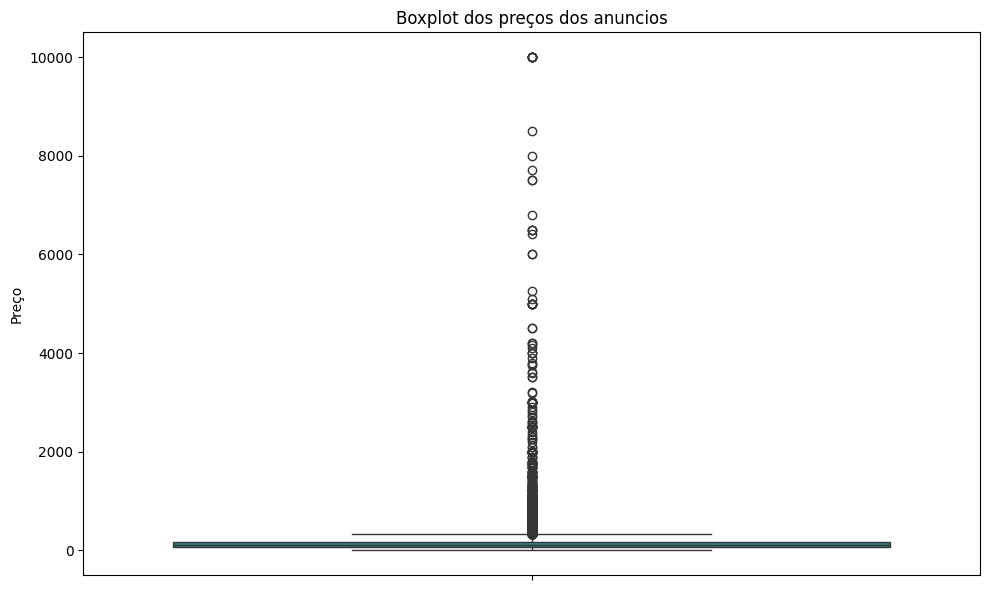

In [ ]:
# Plot the boxplot for 'price' (without x_col)
plotter.boxplot(
    data=data,
    x_col=None,
    y_col="price",
    title="Boxplot dos preços dos anuncios",
    ylabel="Preço",
)


Analisando a coluna `minimo_noites`, que contém o número mínimo de noites que o usuário deve reservar, podemos observar alguns padrões interessantes ao segmentar os preços com base nos valores dessa coluna.  

Primeiramente, ao separar os preços pelos diferentes números de noites mínimas exigidas pelos anfitriões e observar o boxplot, percebemos que a concentração média dos preços não apresenta grandes diferenças entre os valores de `minimo_noites`. Em todas as categorias, o preço médio está em torno de 155 dólares por noite, conforme ilustrado tanto pelo boxplot quanto pela tabela da variável `minimo_noites`.  

No entanto, ao examinar os valores mais elevados, podemos observar que os preços tendem a ser mais altos quando o número mínimo de noites é **1** e também quando é **30**. Essa tendência pode sugerir que os anúncios com essas durações mínimas de estadia têm características especiais ou são de maior valor. Além disso, existe um outlier para o valor de `minimo_noites` igual a **5**, onde o preço registrado é significativamente mais alto que os outros. Esse outlier pode indicar um anúncio com características excepcionais ou um erro de dados.  

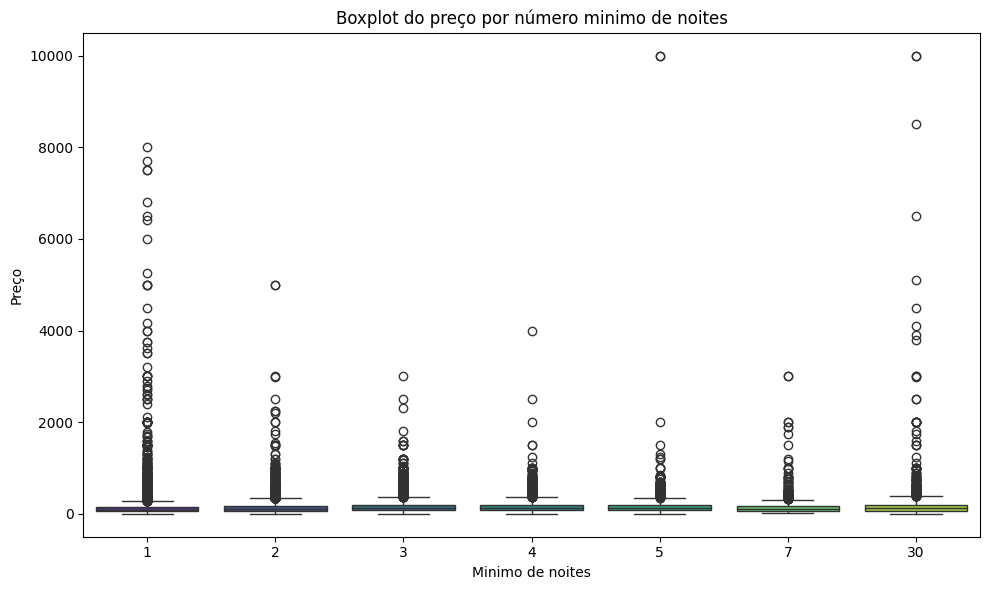

Preço médio por número minimo de noites:
minimo_noites
1     142.02
2     146.27
3     160.25
4     161.19
5     157.31
7     141.19
30    182.56
Name: price, dtype: float64


In [ ]:
# Define the most common values of 'minimo_noites'
common_nights = [1, 2, 3, 30, 4, 5, 7]

# Filter the dataset to include only these values
filtered_data = data[data["minimo_noites"].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(
    data=filtered_data,
    x_col="minimo_noites",
    y_col="price",
    title="Boxplot do preço por número minimo de noites",
    xlabel="Minimo de noites",
    ylabel="Preço",
)

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby("minimo_noites")["price"].mean()
print("Preço médio por número minimo de noites:")
print(mean_prices.round(2))



## Análise de última review - `ultima_review`

É interessante investigar se uma review mais recente impacta no preço médio de um apartamento, como podemos observar no gráfico a seguir, a partir da análise da variável `ultima_review`, que contém a data da última revisão dada à listagem.  

Ao observar o boxplot, podemos perceber que, quanto mais recente a review, maior é a dispersão dos preços, com um número maior de valores mais altos. Isso pode indicar que uma review recente pode estar associada a preços mais elevados. No entanto, essa observação por si só não é suficiente para confirmar uma relação causal entre a recência da review e o preço. 

Para verificar se essa associação é estatisticamente significativa, realizaremos um teste ANOVA, que ajudará a avaliar se há uma diferença significativa nos preços médios entre diferentes grupos de recência das reviews. O p-value obtido a partir do teste ANOVA nos permitirá determinar se a recência das reviews tem um impacto real nos preços ou se a variação observada pode ser atribuída ao acaso.

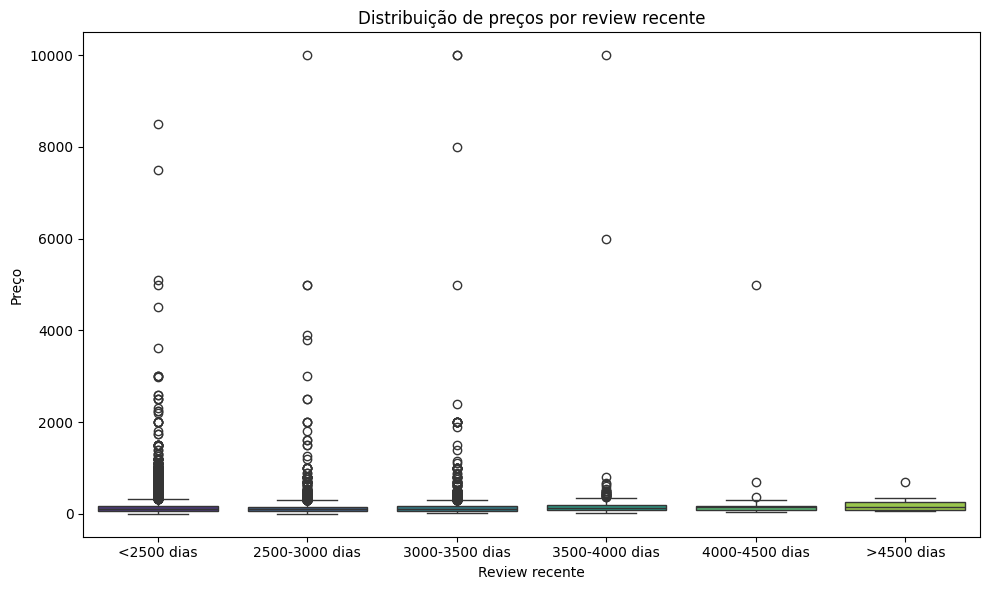

In [ ]:
data["days_since_last_review"] = (pd.Timestamp.today() - data["ultima_review"]).dt.days

# Ensure there are no NaN values in 'days_since_last_review'
data = data.dropna(subset=["days_since_last_review"])

# Define the bins with a lower bound (0)
data["review_recency_category"] = pd.cut(
    data["days_since_last_review"],
    bins=[0, 2500, 3000, 3500, 4000, 4500, data["days_since_last_review"].max()],
    labels=[
        "<2500 dias",
        "2500-3000 dias",
        "3000-3500 dias",
        "3500-4000 dias",
        "4000-4500 dias",
        ">4500 dias",
    ]
)

# Drop NaN values again in case some remain
data = data.dropna(subset=["review_recency_category", "price"])

plotter.boxplot(
    data=data,
    x_col="review_recency_category",
    y_col="price",
    title="Distribuição de preços por review recente",
    xlabel="Review recente",
    ylabel="Preço",
)
)



O p-value de **5.900678200832663e-07** é extremamente baixo, muito menor que o limite de 0,05, o que nos permite tirar as seguintes conclusões:

- **Rejeitamos a hipótese nula**: A hipótese nula, que pressupõe que todas as categorias de "review_recency_category" (recência das avaliações) têm médias de preço iguais, é rejeitada com um nível de confiança elevado. Isso significa que não podemos assumir que os preços são iguais entre os diferentes grupos de recência das avaliações.
  
- **Diferenças significativas**: O p-value tão baixo indica que há uma diferença significativa nas médias de preço entre as categorias de recência das avaliações. Em outras palavras, podemos afirmar com confiança que os preços dos anúncios variam de forma significativa dependendo de quão recente é a avaliação.

- **Influência da recência**: Com base nesses resultados, podemos concluir que a data da última avaliação (ou a recência dessa avaliação) tem um efeito substancial sobre o preço dos apartamentos. Isso sugere que o tempo desde a última revisão tem um impacto real e mensurável no valor listado dos apartamentos.

Em resumo, com esse p-value, podemos concluir de forma robusta que a variável "days_since_last_review", quando transformada em categorias, influencia de maneira significativa o preço dos apartamentos. A recência das avaliações parece ser um fator relevante na determinação do preço médio dos anúncios.

In [ ]:
anova_result = stats.f_oneway(
    *[group["price"].dropna() for _, group in data.groupby("review_recency_category")]
)

print("Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.")
print("Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.")
print(f"ANOVA p-value: {anova_result.pvalue}")


Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.
Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.
ANOVA p-value: 4.806640771930744e-07


# Perguntas

## Supondo  que  uma  pessoa  esteja  pensando  em  investir  em  um apartamento para alugar na plataforma, onde seria mais indicada a compra?

A análise sugere que a melhor opção de compra seria em **Manhattan** ou **Brooklyn**, considerando os preços médios de cada bairro. Em Manhattan, o preço médio é de **197 dólares**, o que o torna o bairro com o preço médio mais alto entre os cinco grupos de bairro analisados. Esse valor mais elevado indica que há um maior potencial de **faturamento**, o que torna Manhattan uma opção atraente para investimentos, pois além de ter o maior preço médio, também representa a maior parte dos anúncios, sugerindo uma demanda significativa.

Em comparação, embora o **Brooklyn** também seja um bairro popular, com preços mais acessíveis que Manhattan, investir em Manhattan pode ser mais vantajoso devido ao maior retorno financeiro, dado o preço médio mais elevado e a maior quantidade de anúncios. Portanto, considerando tanto o preço como a representatividade do bairro no mercado, **Manhattan** se destaca como a melhor opção de compra para maximizar o faturamento.

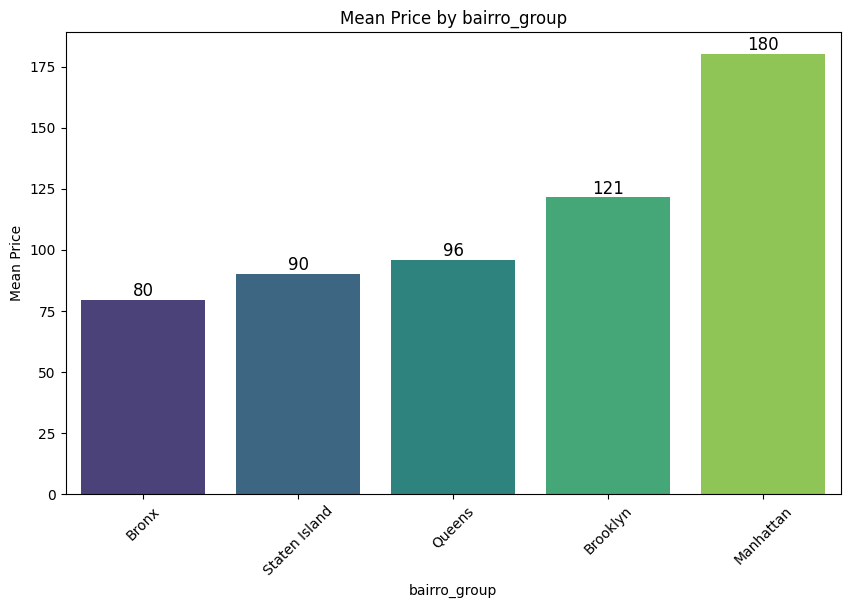

In [ ]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby("bairro_group")["price"].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="bairro_group",
    y_col="price",
    title="Mean Price by bairro_group",
    xlabel="bairro_group",
    ylabel="Mean Price",
    rotation=45,
    show_percentage=False,
)


## O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

### Análise de preço e Número Mínimo de noites

Para fazer esta análise usamos um teste anova com p-value, com isso obtemos que:
O p-value de **5.900678200832663e-07** é extremamente baixo, muito menor que o limite de 0,05, o que nos permite tirar as seguintes conclusões:

- **Rejeitamos a hipótese nula**: A hipótese nula, que pressupõe que todas as categorias de "review_recency_category" (recência das avaliações) têm médias de preço iguais, é rejeitada com um nível de confiança elevado. Isso significa que não podemos assumir que os preços são iguais entre os diferentes grupos de recência das avaliações.
  
- **Diferenças significativas**: O p-value tão baixo indica que há uma diferença significativa nas médias de preço entre as categorias de recência das avaliações. Em outras palavras, podemos afirmar com confiança que os preços dos anúncios variam de forma significativa dependendo de quão recente é a avaliação.

- **Influência da recência**: Com base nesses resultados, podemos concluir que a data da última avaliação (ou a recência dessa avaliação) tem um efeito substancial sobre o preço dos apartamentos. Isso sugere que o tempo desde a última revisão tem um impacto real e mensurável no valor listado dos apartamentos.

Em resumo, com esse p-value, podemos concluir de forma robusta que a variável "days_since_last_review", quando transformada em categorias, influencia de maneira significativa o preço dos apartamentos. A recência das avaliações parece ser um fator relevante na determinação do preço médio dos anúncios.


In [ ]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=["minimo_noites", "price"])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(
    *[group["price"].dropna() for _, group in data.groupby("review_recency_category")]
)

print("Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.")
print("Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.")
print("ANOVA p-value: {}".format(anova_result.pvalue))

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("Existe uma relação significativa entre 'minimo_noites' e 'price'.")
else:
    print("Não há relação significativa entre 'minimo_noites' e 'price'.")


Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.
Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.
ANOVA p-value: 4.806640771930744e-07
Existe uma relação significativa entre 'minimo_noites' e 'price'.


### Análise de preço e Disponibilidade ao longo dos Anos

A análise de preço médio por disponibilidade revela uma relação interessante entre o número de dias disponíveis para reserva e o preço médio do anúncio. Observamos que, para anúncios com baixa disponibilidade, o preço médio tende a ser mais baixo, variando entre 126 e 136 dólares nos primeiros dias. Conforme a disponibilidade aumenta, os preços médios também sobem gradualmente. Para anúncios com 179 dias disponíveis, o preço médio já atinge 183,57 dólares, e para aqueles com 364 ou 365 dias disponíveis, os preços médios são os mais altos, chegando a 214,05 dólares.

Essa tendência sugere que anfitriões que deixam seus imóveis disponíveis para locação durante todo o ano podem praticar preços mais elevados, possivelmente devido a maior experiência na plataforma ou maior demanda por esse tipo de acomodação

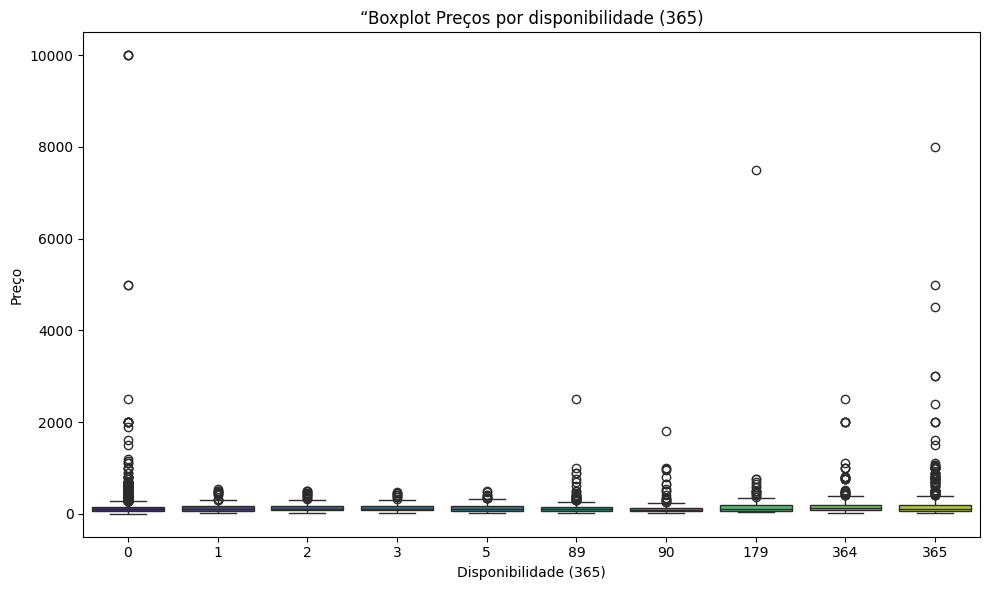

Preços médios por disponibilidade(365):
disponibilidade_365
0      126.72
1      126.85
2      136.12
3      133.15
5      132.08
89     146.32
90     135.42
179    183.57
364    205.46
365    214.05
Name: price, dtype: float64


In [ ]:
# Define the most common values of 'disponibilidade_365'
common_availability = data["disponibilidade_365"].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data_availability = data[data["disponibilidade_365"].isin(common_availability)]

# Create the boxplot for 'disponibilidade_365' using the Plot class
plotter.boxplot(
    data=filtered_data_availability,
    x_col="disponibilidade_365",
    y_col="price",
    title="Boxplot Preços por disponibilidade (365)",
    xlabel="Disponibilidade (365)",
    ylabel="Preço",
)

# Calculate and print the mean prices by 'disponibilidade_365'
mean_prices_availability = filtered_data_availability.groupby("disponibilidade_365")["price"].mean()
print("Preços médios por disponibilidade(365):")
print(mean_prices_availability.round(2))


Os resultados do teste ANOVA indicam que há uma **relação estatisticamente significativa** entre a variável **"disponibilidade_365"** e o **preço** dos anúncios. O **F-statistic de 1.75** sugere que há uma variação relevante nos preços médios entre os diferentes grupos de disponibilidade. Além disso, o **p-value extremamente baixo (próximo de 0.0000)** permite rejeitar a hipótese nula, que assume que não há diferença significativa nos preços entre os grupos.

Isso reforça a ideia de que a **quantidade de dias disponíveis** pode ter um impacto direto no preço praticado pelos anfitriões. Como observado na análise anterior, anúncios com maior disponibilidade tendem a ter preços médios mais elevados, possivelmente devido à demanda contínua ou a um perfil de anfitriões mais experientes que maximizam os ganhos ao longo do ano.

In [ ]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=["disponibilidade_365", "price"])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(
    *(clean_data[clean_data["disponibilidade_365"] == value]["price"]
      for value in clean_data["disponibilidade_365"].unique())
)

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("Existe uma relação significativa entre 'disponibilidade_365' e 'preço'.")
else:
    print("Não há relação significativa entre 'disponibilidade_365' e 'preço'.")



ANOVA Test Results:
F-statistic: 1.75
P-value: 0.0000
Existe uma relação significativa entre 'disponibilidade_365' e 'preço'.


### Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Ao analisar as 10 palavras mais comuns nos anúncios, percebemos que os anfitriões utilizam termos que transmitem uma sensação de **beleza, conforto e aconchego**. O uso dessas palavras sugere uma estratégia para atrair mais clientes, destacando características positivas do espaço e criando uma imagem mais convidativa do local. Essa abordagem pode ser uma forma de **aumentar a demanda e, consequentemente, maximizar o faturamento**, tornando os anúncios mais atraentes e competitivos no mercado.

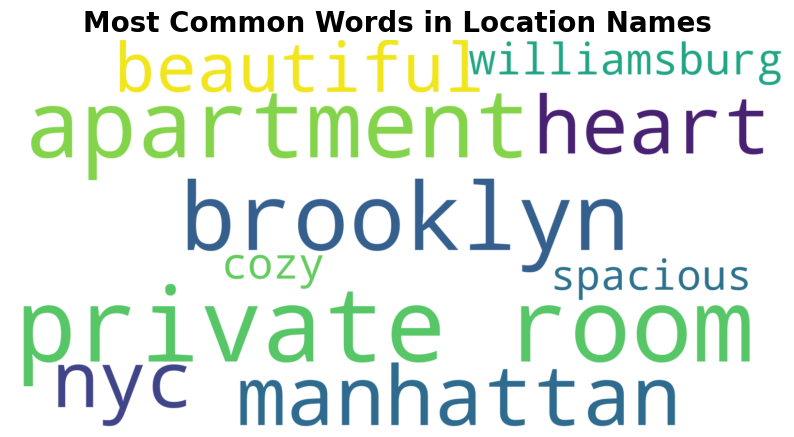

In [42]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_words = plotter.plot_wordcloud(
    data, 
    text_column="nome", 
    max_words=10, 
    title="Palavras mais comuns nos nomes do anuncio"
)



Ao observarmos os dados, percebemos que existe uma associação entre o padrão de texto utilizado nos anúncios e os valores mais altos de preço. Palavras como **"studio", "spacious", "Manhattan", "bedroom"** e **"apt"** estão frequentemente relacionadas a acomodações mais caras. Isso sugere que termos que destacam características como **espaço, localização privilegiada e conforto** podem estar associados a preços mais elevados, refletindo o valor percebido pelo cliente na escolha do imóvel.

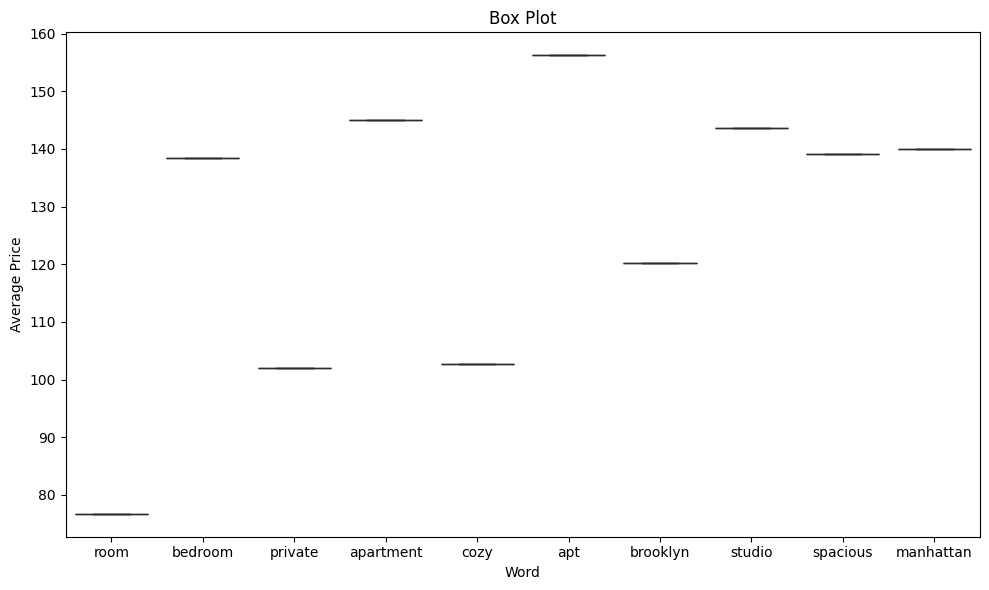

In [43]:
# Plot price distributions from common words
df_price_distribution = aux.plot_price_distribution(
    data=data, text_column="nome", price_column="price", df_words=df_words
)


# Modelling

### **Etapas de Pré-processamento**  

Neste código, estamos criando um pipeline para transformar os dados de forma adequada para um modelo de machine learning, garantindo que todas as variáveis sejam tratadas corretamente antes da modelagem.  

### **1. Cópia dos Dados**  
Inicialmente, criamos uma cópia do dataset original (`data.copy()`). Isso é essencial para preservar os dados originais e evitar modificações indesejadas que possam comprometer a integridade do conjunto de dados.  

### **2. Escolha das Variáveis**  

- **Variáveis Categóricas**: São aquelas que representam grupos ou categorias distintas. Essas variáveis serão transformadas utilizando a técnica de codificação `OneHotEncoder`, que converte cada categoria em uma coluna binária. As variáveis escolhidas foram:  
  - `bairro_group`, `bairro`, `room_type`, `gender`  
  Essas variáveis foram selecionadas com base na análise exploratória dos dados, pois demonstraram estar correlacionadas com variações nos preços dos anúncios.  

- **Variáveis Numéricas**: Contêm valores contínuos e, neste caso, serão mantidas sem transformação. As variáveis utilizadas são:  
  - `minimo_noites`, `numero_de_reviews`, `reviews_por_mes`,  
    `calculado_host_listings_count`, `disponibilidade_365`, `days_since_last_review`  
  Essas variáveis numéricas foram mantidas integralmente, pois representam informações relevantes que podem impactar a previsão do preço.  

### **3. Remoção de Valores Nulos**  
As linhas com valores faltantes (`NaN`) são removidas para garantir que o modelo seja treinado apenas com dados completos e consistentes.  

### **4. Transformações**  

- **Variáveis Categóricas**: São codificadas utilizando `OneHotEncoder`, transformando cada categoria em uma variável binária. Isso permite que o modelo utilize informações categóricas sem perder relações importantes entre os grupos.  
- **Variáveis Numéricas**: São passadas diretamente para o modelo (`passthrough`), pois já estão no formato adequado para a modelagem.  

### **5. Pipeline de Pré-processamento**  
Por fim, um pipeline é criado utilizando `ColumnTransformer`, aplicando as transformações de forma separada para variáveis categóricas e numéricas. Isso garante que os dados estejam padronizados e preparados para alimentar o modelo de machine learning.  

---

### **Descrição do Problema**  

O problema que estamos abordando é um **problema de regressão**, pois buscamos prever o preço dos anúncios, que é uma variável numérica contínua. Modelos de regressão são utilizados quando o objetivo é estimar um valor quantitativo a partir de um conjunto de variáveis preditoras.  

No contexto deste projeto, nosso modelo de regressão aprenderá a identificar padrões nos dados e a prever o preço de um imóvel com base em características como localização (`bairro`, `bairro_group`), tipo de acomodação (`room_type`), características do anfitrião (`calculado_host_listings_count`), disponibilidade (`disponibilidade_365`), entre outras variáveis.  

O objetivo final é desenvolver um modelo robusto que possa fornecer estimativas precisas de preços, auxiliando tanto proprietários quanto consumidores a tomar decisões mais embasadas no mercado de hospedagem.  

---

### **Métricas de Avaliação**  

Para avaliar o desempenho do modelo, utilizamos três métricas principais: **MAE (Mean Absolute Error)**, **\( R^2 \) (Coeficiente de Determinação)** e **Theil’s U Statistic**.  

- **MAE (Erro Médio Absoluto)**: Mede a média dos erros absolutos entre os valores reais e as previsões. Essa métrica é útil porque fornece uma interpretação direta do erro médio em unidades da variável de resposta (neste caso, o preço). Quanto menor o MAE, melhor o desempenho do modelo.  

- **\( R^2 \) (Coeficiente de Determinação)**: Mede a proporção da variabilidade da variável resposta que é explicada pelo modelo. O \( R^2 \) varia entre 0 e 1, onde valores mais próximos de 1 indicam um ajuste melhor do modelo aos dados.  

- **Theil’s U Statistic**: Essa métrica compara a performance do modelo com a de um modelo ingênuo (como uma previsão baseada na média dos valores passados). Se \( U < 1 \), o modelo é melhor que a previsão ingênua; se \( U > 1 \), o modelo apresenta desempenho inferior. Essa métrica é útil para avaliar se o modelo realmente traz melhorias em relação a previsões simples.  

O uso dessas métricas permite uma avaliação abrangente do modelo, considerando tanto o erro absoluto quanto a capacidade de explicação dos dados e sua efetividade em relação a um modelo de referência.

In [16]:
data_modelling = data.copy()

# Define the columns
categorical_features = [
    "bairro_group", "bairro", "room_type", "gender"
]
numerical_features = [
    "minimo_noites", "numero_de_reviews", "reviews_por_mes",
    "calculado_host_listings_count", "disponibilidade_365", "days_since_last_review"
]

# Remove rows with NaN values
data_modelling = data_modelling.dropna()

# Transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Transformer for numeric variables (no transformation applied)
numerical_transformer = "passthrough"

# Applying transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])



1. **Separação das Colunas de Features e Target**:
   - **`y = data_modelling["price"]`**: A variável target (`y`) é definida como a coluna `price`, que contém o preço dos anúncios e é o que queremos prever.
   - **`X = data_modelling.drop(columns=["price"])`**: As features (`X`) são todas as colunas do dataset, exceto a coluna `price`. Ou seja, todas as variáveis preditoras serão usadas para treinar o modelo.

2. **Divisão em Conjunto de Treinamento e Temporário**:
   - **`train_test_split(X, y, test_size=0.3, random_state=42)`**: A função `train_test_split` é utilizada para dividir os dados em dois conjuntos:
     - **Treinamento (70%)**: A maior parte dos dados, que será usada para treinar o modelo.
     - **Temporário (30%)**: A parte restante, que será dividida posteriormente entre validação e teste. A semente `random_state=42` é definida para garantir que a divisão seja reprodutível.

   Aqui, os dados são divididos em `X_train`, `X_temp` (features) e `y_train`, `y_temp` (target), onde:
   - `X_train` e `y_train` são os dados de treinamento.
   - `X_temp` e `y_temp` contêm os dados temporários, que serão separados em validação e teste na próxima etapa.

3. **Divisão do Conjunto Temporário em Validação e Teste**:
   - **`train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)`**: Agora, os dados temporários (`X_temp`, `y_temp`) são divididos novamente em:
     - **Validação (20%)**: Esse conjunto será usado para avaliar o desempenho do modelo durante o treinamento e ajustar parâmetros.
     - **Teste (10%)**: Esse conjunto será utilizado para testar o modelo final após o treinamento.

   A divisão aqui é feita com `test_size=1/3`, ou seja, 1/3 dos dados temporários são alocados para o conjunto de teste, deixando 2/3 para validação.

4. **Aplicação das Transformações do Pipeline**:
   - **`X_train_transformed = pipeline.fit_transform(X_train)`**: O pipeline, que aplica as transformações necessárias nas variáveis (como a codificação das variáveis categóricas), é ajustado (fit) e transformado (transform) no conjunto de treinamento (`X_train`).
   - **`X_val_transformed = pipeline.transform(X_val)`** e **`X_test_transformed = pipeline.transform(X_test)`**: Para os conjuntos de validação e teste, apenas a transformação é aplicada (sem o ajuste), garantindo que as transformações sejam consistentes com as realizadas no conjunto de treinamento.


In [17]:
# Separate columns features and target
y = data_modelling["price"]
X = data_modelling.drop(columns=["price"])

# Split into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Split the temporary set into validation (20%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# Applying the transformations from the pipeline
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)




# Regressão Linear

Os resultados da regressão linear mostram um desempenho relativamente baixo do modelo na predição dos dados. Primeiramente, a escolha do hiperparâmetro fit_intercept=False indica que o modelo foi treinado sem um termo de interceptação, assumindo que os dados já estavam centralizados ou que a relação entre as variáveis explicativas e a variável-alvo não requer um deslocamento adicional.

O coeficiente de determinação 𝑅², que mede a proporção da variância explicada pelo modelo, é de 0,2288 para o conjunto de validação. Esse valor sugere que apenas cerca de 22,88% da variação da variável dependente é explicada pelo modelo, indicando um ajuste fraco.

Nas métricas de erro, o Erro Médio Absoluto (MAE) foi 59,63, o que indica o erro médio em unidades da variável predita. Esse valor sugere que, em média, as previsões do modelo se desviam cerca de 59,63 unidades dos valores reais.

O Theil’s U foi 0,4439, o que indica que o modelo possui um erro considerável em relação a uma previsão ingênua (como uma previsão baseada na média passada). Em geral, valores de Theil próximos de 0 indicam boas previsões, enquanto valores acima de 1 sugerem um modelo pouco útil. O valor obtido (próximo de 0,44) indica que o modelo tem um desempenho melhor do que uma previsão ingênua, mas ainda apresenta limitações.

No geral, os resultados sugerem que a regressão linear não capturou adequadamente a relação entre as variáveis do conjunto de dados.

In [18]:
# Define the model and parameter grid
model_lr = LinearRegression()


param_grids_lr = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
}

# Configure GridSearchCV (without automatic refitting)
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring='r2',
    cv=5,  
    n_jobs=-1,
    refit=True  
)


best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lr,
    grid_search=grid_search_lr,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)

------------------------------Melhores hiperparâmetros------------------------------
fit_intercept: True
--------------------------------------------------------------------------------
------------------------------Métricas de R² para o modelo------------------------------
R² para o conjunto de validação: 0.23

------------------------------Métricas  para o modelo------------------------------
              model        MAE        R2     theil
0  LinearRegression  59.498186  0.106877  0.443914


Em termos de erro médio absoluto (MAE), o Lasso teve um desempenho ligeiramente melhor, com um valor de 59.095 em comparação com 59.498 da Regressão Linear.  
Isso significa que, em média, os erros absolutos do Lasso foram um pouco menores, indicando previsões mais precisas. O coeficiente de determinação R², que mede a capacidade do modelo de explicar a variabilidade dos dados, foi praticamente o mesmo para ambos os modelos, ficando em torno de 0.1069. Esse valor relativamente baixo sugere que nenhum dos modelos conseguiu capturar bem a relação entre as variáveis preditoras e a variável alvo. 
Além disso, o índice de Theil, que avalia a precisão das previsões em comparação com um modelo de referência, também foi praticamente idêntico nos dois casos, ficando em torno de 0.4439, reforçando que ambos os modelos tiveram desempenhos muito próximos.   
No entanto, o Lasso pode ter uma leve vantagem, pois além de apresentar um erro médio um pouco menor, ele tem a capacidade de penalizar coeficientes irrelevantes, ajudando a evitar overfitting e tornando o modelo mais robusto. No entanto, dado o baixo R², pode ser interessante testar abordagens diferentes, como a inclusão de novas variáveis, transformação dos dados ou até mesmo modelos mais sofisticados que consigam capturar melhor a estrutura dos dados.

In [19]:
# Define the model
model_lasso =  Lasso()

# paramns for model
param_grids_lasso = {

    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    }
}


# Configure GridSearchCV for hyperparameter tuning
grid_search_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grids_lasso['Lasso'],
    scoring="r2",
    cv=5,  
    n_jobs=-1 
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lasso,
    grid_search=grid_search_lasso,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


------------------------------Melhores hiperparâmetros------------------------------
alpha: 0.1
--------------------------------------------------------------------------------
------------------------------Métricas de R² para o modelo------------------------------
R² para o conjunto de validação: 0.22

------------------------------Métricas  para o modelo------------------------------
              model        MAE        R2     theil
0  LinearRegression  59.498186  0.106877  0.443914
1             Lasso  59.095208  0.106881  0.443913


Os resultados mostram o desempenho de três modelos de regressão: Regressão Linear, Lasso e Random Forest. Comparando as métricas, observa-se que o **Random Forest Regressor** teve o melhor desempenho entre os três, com um erro médio absoluto (MAE) de 53.449, significativamente menor do que os valores de 59.498 da Regressão Linear e 59.095 do Lasso.  
Isso indica que as previsões do Random Forest foram, em média, mais próximas dos valores reais. Além disso, o coeficiente de determinação R² para o Random Forest foi de 0.141, um aumento em relação aos 0.106 dos outros modelos, sugerindo que ele conseguiu explicar uma parcela maior da variabilidade dos dados.  
O índice de Theil também foi menor para o Random Forest (0.426), reforçando que suas previsões foram mais confiáveis e menos distantes da realidade em comparação com os demais modelos. Esses resultados indicam que o Random Forest conseguiu capturar melhor os padrões dos dados, possivelmente devido à sua capacidade de modelar relações não lineares e interações entre variáveis, o que os modelos lineares não conseguem fazer. 
Mesmo assim, o R² de 0.141 ainda é relativamente baixo, sugerindo que há espaço para melhorias, seja por meio do ajuste de hiperparâmetros, inclusão de novas variáveis ou experimentação com outros modelos mais sofisticados.

In [20]:
# Define the model
model_rf = RandomForestRegressor()


# Define the hyperparameter grid for tuning
param_grids_rf = {
    'Random Forest': {
        'n_estimators': [40, 50],
        'max_depth': [None, 30, 40],
        'min_samples_split': [2, 8],
        'min_samples_leaf': [1, 9],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(), 
    param_grid=param_grids_rf['Random Forest'], 
    scoring='r2',
    cv=5,
    n_jobs=-1
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_rf,
    grid_search=grid_search_rf,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


------------------------------Melhores hiperparâmetros------------------------------
bootstrap: False
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 8
n_estimators: 40
--------------------------------------------------------------------------------
------------------------------Métricas de R² para o modelo------------------------------
R² para o conjunto de validação: 0.25

------------------------------Métricas  para o modelo------------------------------
                   model        MAE        R2     theil
0       LinearRegression  59.498186  0.106877  0.443914
1                  Lasso  59.095208  0.106881  0.443913
2  RandomForestRegressor  53.449370  0.141283  0.426797


# Prevendo novo valor suposto

Nesta etapa, buscamos prever um novo valor com base nos dados e no modelo desenvolvido, conforme proposto pelo desafio. Para isso, criamos uma nova entrada contendo as características especificadas e aplicamos os mesmos tratamentos e pré-processamentos utilizados anteriormente nos dados de treinamento. Dessa forma, garantimos que a nova entrada esteja no formato adequado para ser processada pelo modelo e gerar uma previsão precisa.

In [ ]:
new_data = {
    'id': 2595,  
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

# Create a DataFrame with input data
input_df = pd.DataFrame([new_data])

# Apply predict_gender on 'host_name' column
input_df['gender'] = input_df['host_name'].apply(
    lambda name: aux.predict_gender(name)
)

# Replace specific gender values for consistency
input_df['gender'] = input_df['gender'].replace(
    {'mostly_female': 'female', 'mostly_male': 'male'}
)

# Convert 'ultima_review' to date format
input_df['ultima_review'] = pd.to_datetime(input_df['ultima_review'])

# Create 'days_since_last_review' column
input_df['days_since_last_review'] = (
    pd.Timestamp.today() - input_df['ultima_review']
).dt.days

# Ensure there are no NaN values in 'days_since_last_review'
input_df = input_df.dropna(subset=['days_since_last_review'])

# Using the pipeline for transformation
teste_new = pipeline.transform(input_df)



Abaixo fazemos a previsão com o modelo que se saiu melhor com os dados, o modelo de floresta aleátoria.

In [ ]:
y_pred_rf_new = grid_search_rf.best_estimator_.predict(teste_new)
print("Valor da Previsão com RandomForest",y_pred_rf_new)

Nesta etapa, salvamos o **modelo Random Forest**, que apresentou o melhor desempenho entre os modelos avaliados, na pasta **models**.    
O modelo Random Forest foi escolhido devido à sua capacidade de capturar padrões complexos nos dados e seu bom desempenho nas tarefas de previsão.   
Ao salvar o modelo, garantimos que ele possa ser carregado e reutilizado futuramente para fazer previsões em novos dados, sem a necessidade de treinar o modelo novamente. Isso também facilita a integração do modelo em aplicações ou pipelines de produção.

In [ ]:
joblib.dump(grid_search_rf.best_estimator_, 'models/modelo_RandomForest.pkl')

# Verificando se a pasta 'modelo' existe, senão cria
if not os.path.exists('models'):
    os.makedirs('models')